In [1]:
import sys
sys.path.append('..')

In [2]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from matplotlib import pyplot as plt
from matplotlib.collections import PolyCollection
from CommonFunctions import *
%matplotlib inline

In [3]:
dataset = pd.read_csv('Retail_sales_of_electricity_United_States_monthly.csv', header=4)
dataset.drop_duplicates(subset='Month', inplace=True)
dataset.set_index('Month', inplace=True)
dataset.index = pd.to_datetime(dataset.index, format='%b %Y')
dataset.dropna(inplace=True)
dataset = dataset['all sectors million kilowatthours']
dataset = dataset.iloc[::-1]
dataset.rename('All sectors [MkWh]', inplace=True)
dataset

Month
2000-12-01    310816.06880
2001-01-01    272334.73804
2001-02-01    269298.40142
2001-03-01    254390.93545
2001-04-01    264490.49166
                  ...     
2022-06-01    389214.17473
2022-07-01    389626.28230
2022-08-01    340543.84071
2022-09-01    297195.94414
2022-10-01    292257.74617
Name: All sectors [MkWh], Length: 263, dtype: float64

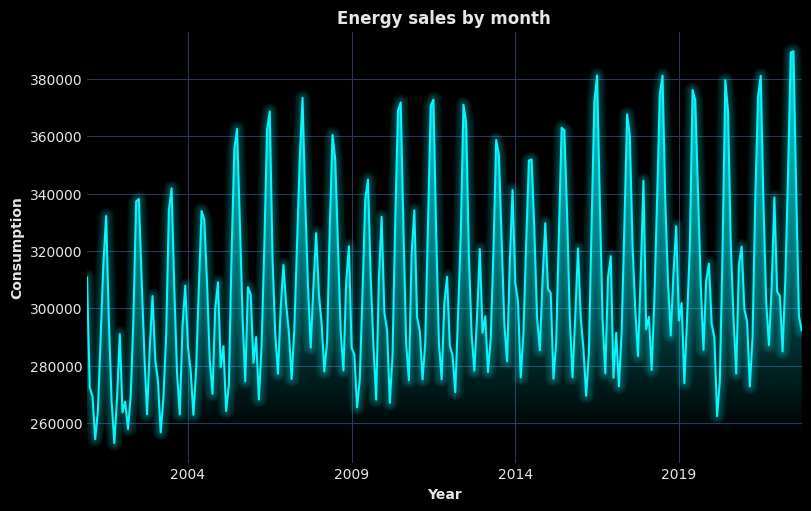

In [4]:
with plt.style.context('cyberpunk'):
    figure, axes = plt.subplots(1, 1, layout='constrained', figsize=(8, 5))
    dataset.plot(ax=axes)
    axes.set(xlabel='Year', ylabel='Consumption', title='Energy sales by month')
    enhance_plot(figure, axes, glow=True, alpha_gradient=0.8)
figure.savefig('./images/ElectricityData1.png');

Differencing over period 12

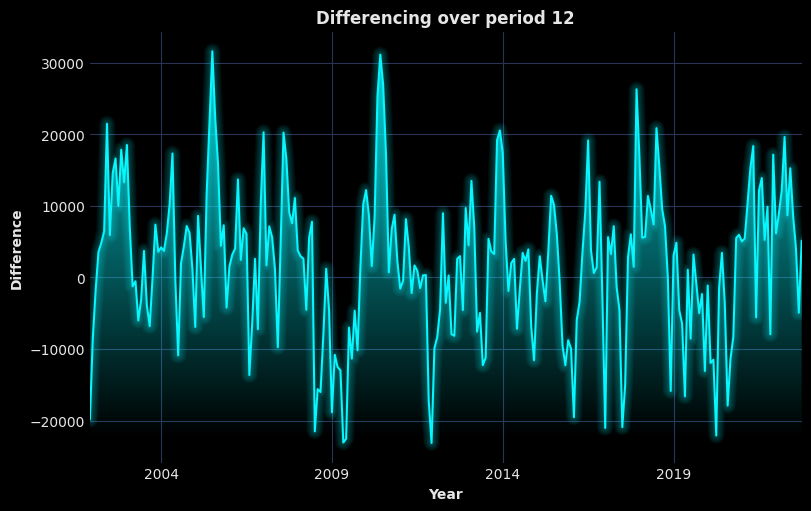

In [5]:
dataset_seasonal_diff = dataset.diff(periods=12).dropna()
with plt.style.context('cyberpunk'):
    figure, axes = plt.subplots(1, 1, layout='constrained', figsize=(8, 5))
    dataset_seasonal_diff.plot(ax=axes)
    axes.set(xlabel='Year', ylabel='Difference', title='Differencing over period 12')
    enhance_plot(figure, axes, glow=True, alpha_gradient=0.8)
figure.savefig('./images/ElectricityData2.png');

First order differencing

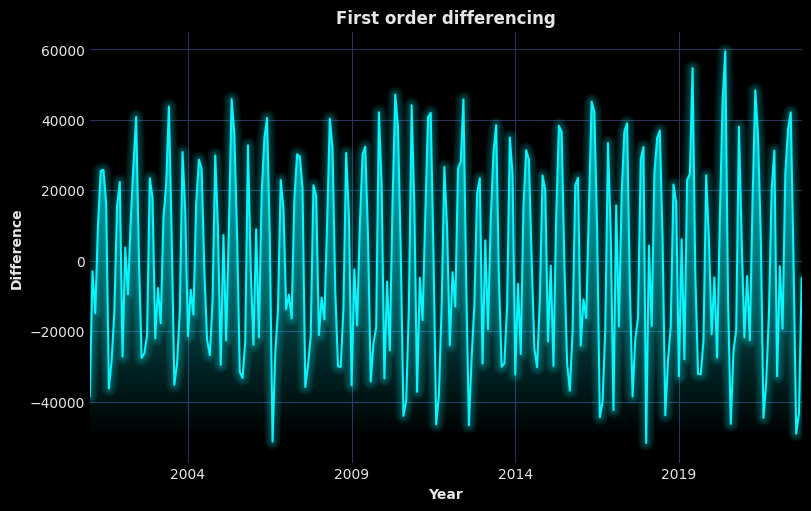

In [6]:
dataset_diff = dataset.diff().dropna()
with plt.style.context('cyberpunk'):
    figure, axes = plt.subplots(1, 1, layout='constrained', figsize=(8, 5))
    dataset_diff.plot(ax=axes)
    axes.set(xlabel='Year', ylabel='Difference', title='First order differencing')
    enhance_plot(figure, axes, glow=True, alpha_gradient=0.8)
figure.savefig('./images/ElectricityData3.png');

Both types of differencing combined

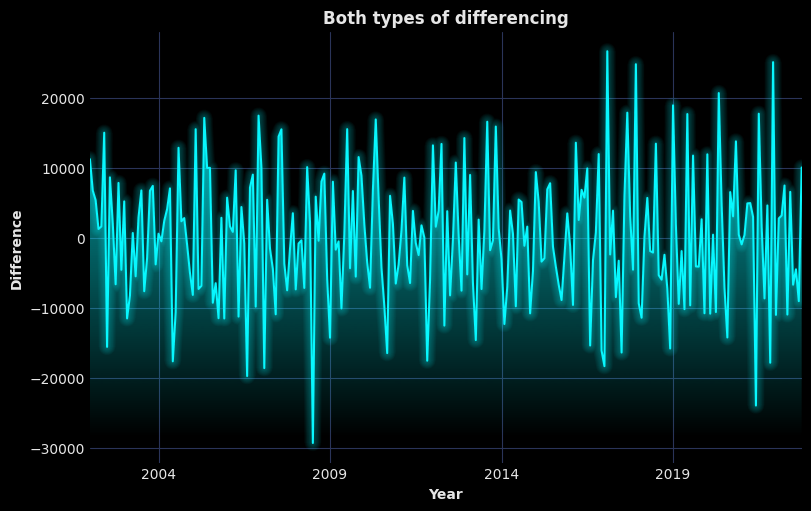

In [7]:
dataset_diff_combined = dataset_seasonal_diff.diff().dropna()
with plt.style.context('cyberpunk'):
    figure, axes = plt.subplots(1, 1, layout='constrained', figsize=(8, 5))
    dataset_diff_combined.plot(ax=axes)
    axes.set(xlabel='Year', ylabel='Difference', title='Both types of differencing')
    enhance_plot(figure, axes, glow=True, alpha_gradient=0.8)
figure.savefig('./images/ElectricityData4.png');

Let's analyze the data.

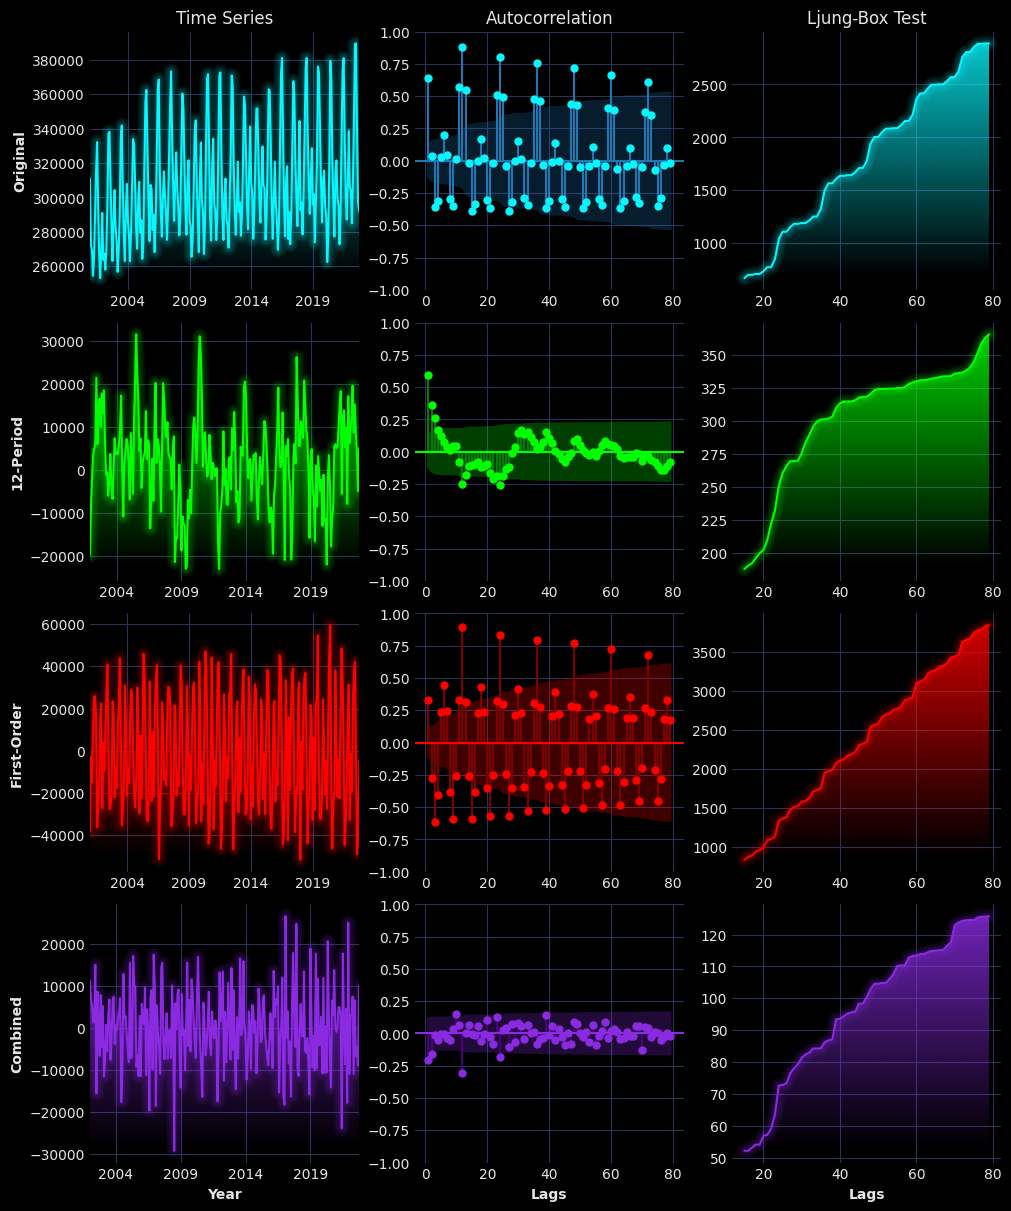

In [8]:
max_lag = 80
colors = [None, 'lime', 'red', 'blueviolet']
bg_colors = [None, 'green', 'maroon', 'indigo']
titles = ['Original', '12-Period', 'First-Order', 'Combined']
series_list = [dataset, dataset_seasonal_diff, dataset_diff, dataset_diff_combined]
with plt.style.context('cyberpunk'):
    figure, axes = plt.subplots(4, 3, layout='constrained', figsize=(10, 12))
    for index, (series, title, color) in enumerate(zip(series_list, titles, colors)):
        series.plot(ax=axes[index, 0], color=color)
        axes[index, 0].set(ylabel=title, xlabel=None)
        enhance_plot(figure, axes[index, 0], glow=True, alpha_gradient=0.8)
    axes[0, 0].set_title('Time Series')
    axes[3, 0].set(xlabel='Year')
    for index, (series, color, bg_color) in enumerate(zip(series_list, colors, bg_colors)):
        plot_acf(series, ax=axes[index, 1], lags=range(1, max_lag), color=color,
                 vlines_kwargs=dict(color=bg_color), title=None)
        for item in axes[index, 1].collections:
            if type(item) == PolyCollection:
                item.set_facecolor(color)
        enhance_plot(figure, axes[index, 1])
    axes[0, 1].set(title='Autocorrelation')
    axes[3, 1].set(xlabel='Lags')
    for index, (series, color) in enumerate(zip(series_list, colors)):
        acorr_ljungbox(series, lags=range(15, max_lag), return_df=True)\
        .lb_stat.plot(ax=axes[index, 2], color=color)
        enhance_plot(figure, axes[index, 2], glow=True, alpha_gradient=0.8)
    axes[0, 2].set(title='Ljung-Box Test')
    axes[3, 2].set(xlabel='Lags')
figure.savefig('./images/ElectricityData5.png');

We can see that only combining both types of differencing reduces autocorrelations

# Augmented Dickey-Fuller Test

### Original Series

In [9]:
adfuller(dataset)

(-2.4253504768624916,
 0.13470887339265847,
 12,
 250,
 {'1%': -3.456780859712, '5%': -2.8731715065600003, '10%': -2.572968544},
 5145.37504653484)

### 12-Period Differencing

In [10]:
adfuller(dataset_seasonal_diff)

(-4.546625507611711,
 0.00016181776556163795,
 12,
 238,
 {'1%': -3.458128284586202,
  '5%': -2.873761835239286,
  '10%': -2.5732834559706235},
 4888.972997233189)

### First Order Differencing

In [11]:
adfuller(dataset_diff)

(-7.782579735445599,
 8.341132095469743e-12,
 11,
 250,
 {'1%': -3.456780859712, '5%': -2.8731715065600003, '10%': -2.572968544},
 5129.643970449506)

### Combined

In [12]:
adfuller(dataset_diff_combined)

(-6.117347392269701,
 9.02762378579757e-08,
 11,
 238,
 {'1%': -3.458128284586202,
  '5%': -2.873761835239286,
  '10%': -2.5732834559706235},
 4885.559998355292)

We can see that first order differencing reduces stationarity well because of the negative ADF value increasing